# Clustering and Association Rules


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import plotly
import plotly.graph_objs as go

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

from tqdm.notebook import tqdm

%matplotlib inline

## Exercise 1 - Clustering

### Data Preparation
Here is the the dataset from Autoscout24. We reuse the steps that we developed in the regression exercise to read and clean the data:

In [2]:
df = pd.read_csv("cars.csv")
df['Age'] = df.Year-1984
df.drop(['Color', 'Name', 'Registration', 'Year'], axis='columns', inplace=True)
df.drop_duplicates(inplace=True)
df.drop([17010, 7734, 47002, 44369, 24720, 50574, 36542, 42611,
         22513, 12773, 21501, 2424, 52910, 29735, 43004, 47125], axis='rows', inplace=True)
df.drop(df.index[df.EngineSize > 7500], axis='rows', inplace=True)

Above reads the data, removes unneeded columns and some outliers. All categorical variables have been removed for this exercise.

In [3]:
df.head()

Price  Mileage  Doors  Horsepower  EngineSize  Seats  Cylinders  Gears  \
0   44800    27600      2         320        4973      2          8      5   
1   22800    18300      4         286        4398      5          8      5   
2  183710      650      5         350        4172      5          8      6   
3   19900    32000      5         150        2198      7          4      6   
4   18999   118000      5         163        2401      5          5      5   

   Age  
0   12  
1   15  
2   24  
3   22  
4   19

In [4]:
df.describe()

Price       Mileage         Doors    Horsepower    EngineSize  \
count   53843.000000   53843.00000  53843.000000  53843.000000  53843.000000   
mean    29736.330999   53678.33360      4.336980    171.828947   2120.123526   
std     30550.497496   59523.69491      1.048416     93.304944    961.810195   
min       300.000000       0.00000      2.000000     40.000000    599.000000   
25%     11938.500000    2000.00000      4.000000    113.000000   1560.000000   
50%     21900.000000   31000.00000      5.000000    150.000000   1968.000000   
75%     36900.000000   90500.00000      5.000000    200.000000   2324.000000   
max    489000.000000  450000.00000      5.000000    736.000000   7011.000000   

              Seats     Cylinders         Gears           Age  
count  53843.000000  53843.000000  53843.000000  53843.000000  
mean       4.805119      4.567056      5.796074     24.627862  
std        0.911667      1.369624      0.857852      4.406785  
min        2.000000      2.000000      3.000000      1.000000  
25%        5.000000      4.000000      5.000000     22.000000  
50%        5.000000      4.000000      6.000000     26.000000  
75%        5.000000      4.000000      6.000000     28.000000  
max        9.000000     12.000000      8.000000     30.000000

### K-Means Clustering
We want to find out if we can group the cars somehow, in order to better understand what kind of cars are offered on the platform.

First let us create the training set X.

In [5]:
X = df.values

> Appy the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) estimator from Scikit-Learn to cluster the X. Create three clusters and set the `random_state` to 0.

In [6]:
est = KMeans(n_clusters=3, random_state=0).fit(X)

In [ ]:
est = KMeans(n_clusters=3, random_state=0).fit(X)

The clusters that K-Means assigns to each sample can be found in `est.labels_`

In [7]:
labels = est.labels_
labels[0:10]

array([1, 1, 1, 1, 2, 2, 2, 0, 2, 2], dtype=int32)

Let's plot the clusters. Without dimensionality reduction, we can only plot three dimensions at one time. We start by plotting *Mileage*, *Horsepower* and *Age* on the axes and the assigned cluster as the color.

<ipython-input-8-6acdc55d10a2>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


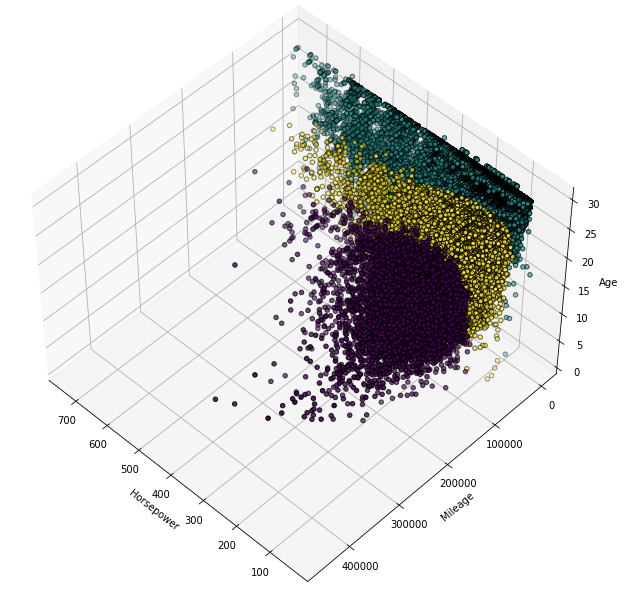

In [8]:
fig = plt.figure(1, figsize=(10, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(xs = X[:, 3], ys = X[:, 1], zs = X[:, 8], c=labels.astype(np.float), edgecolor='k')
ax.set_xlabel('Horsepower'); 
ax.set_ylabel('Mileage'); 
ax.set_zlabel('Age')
fig.show()

We see a clear separation of clusters for Mileage. The other two plotted dimensions do not show such a clear separation. Can you imagine why Mileage is somewhat dominating? 

> Write your answer below.

We forgot to scale the dataset. K-Means, like other distance- or similarity based algorithms, is impacted by the scale of the features.

Wer fix this and rerun the plotting. We want to keep the original X so we can plot the dots in the original scale.

In [9]:
scaler = RobustScaler()
X_transformed = scaler.fit_transform(X)
est = KMeans(n_clusters=3, random_state=0).fit(X_transformed)
labels = est.labels_

<ipython-input-10-6acdc55d10a2>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


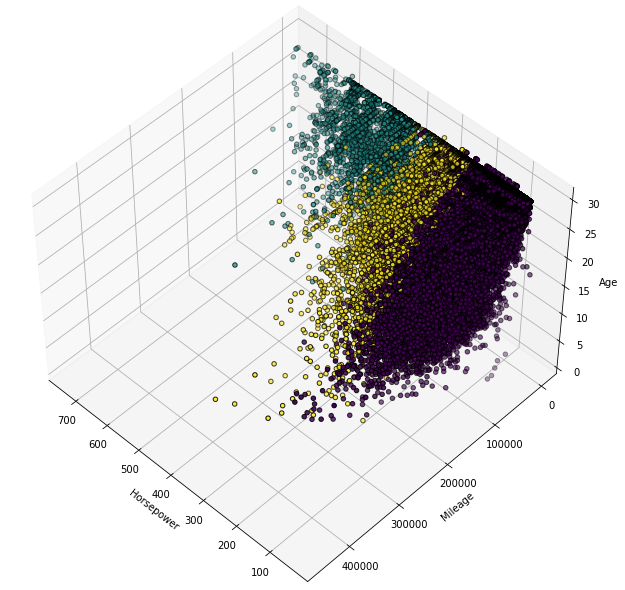

In [10]:
fig = plt.figure(1, figsize=(10, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(xs = X[:, 3], ys = X[:, 1], zs = X[:, 8], c=labels.astype(np.float), edgecolor='k')
ax.set_xlabel('Horsepower'); 
ax.set_ylabel('Mileage'); 
ax.set_zlabel('Age')
fig.show()

Now the separation is a bit less clear and shifted towards Horsepower. We will look at this in a more visible way a bit later.

#### Cluster centers
The cluster centers can be found in 

In [11]:
est.cluster_centers_

array([[ 0.04288235,  0.20781519, -0.52727358, -0.15875646, -0.31859058,
        -0.10227593, -0.0277203 , -0.29194489, -0.1467836 ],
       [ 3.68016311, -0.02071496, -2.13542435,  3.5925351 ,  3.89917022,
        -1.46752768,  4.61107011,  0.37343173, -0.27546125],
       [ 0.59367278,  0.58304122, -0.87036391,  1.2238192 ,  1.59335758,
        -0.25183118,  2.23404255,  0.04941286, -0.61897841]])

However, these are the transformed cluster centers, if we want to examine or plot them, we need to unscale them (since we have not scaled X).

In [12]:
centers = scaler.inverse_transform(est.cluster_centers_)
centers

array([[2.29704079e+04, 4.93916443e+04, 4.47272642e+00, 1.36188188e+02,
        1.72459680e+03, 4.89772407e+00, 3.97227970e+00, 5.70805511e+00,
        2.51192984e+01],
       [1.13762392e+05, 2.91667262e+04, 2.86457565e+00, 4.62550554e+02,
        4.94696605e+03, 3.53247232e+00, 8.61107011e+00, 6.37343173e+00,
        2.43472325e+01],
       [3.67189631e+04, 8.25991479e+04, 4.12963609e+00, 2.56472271e+02,
        3.18532519e+03, 4.74816882e+00, 6.23404255e+00, 6.04941286e+00,
        2.22861295e+01]])

#### Assign a data point to a cluster
We can pick a random point and calculate the distances to all cluster centers. 

The first step is to normalize our sample datapoint.

In [15]:
centers = est.cluster_centers_

x_sample = scaler.transform([X[16]])
print(x_sample)

[[ 0.32049356 -0.06779661  0.          0.22988506  0.03926702  0.
   0.          0.          0.        ]]


> Calculate the three [euclidean distances](https://en.wikipedia.org/wiki/Euclidean_distance) of point `x_sample` to the cluster centers.

In [16]:
centers = est.cluster_centers_
x_sample = scaler.transform([X[16]])

distances = []
for i in range(len(centers)):
    dist = np.sqrt(np.sum(np.square(x_sample - centers[i])))
    # dist = np.linalg.norm(x_sample - centers[i]) # this works as well
    distances.append(dist)
    print("Distance to center of cluster {} is {}.".format(i, dist))
y_pred = np.argmin(distances)
print("Datapoint is assigned to cluster", y_pred)

Distance to center of cluster 0 is 0.9100316430153006.
Distance to center of cluster 1 is 8.104741614230651.
Distance to center of cluster 2 is 3.1778599195621724.
Datapoint is assigned to cluster 0


In [ ]:
centers = est.cluster_centers_
x_sample = scaler.transform([X[16]])

distances = []
for i in range(len(centers)):
    dist = np.sqrt(np.sum(np.square(x_sample - centers[i])))
    # dist = np.linalg.norm(x_sample - centers[i]) # this works as well
    distances.append(dist)
    print("Distance to center of cluster {} is {}.".format(i, dist))
y_pred = np.argmin(distances)
print("Datapoint is assigned to cluster", y_pred)

We can check if our code is correct by accessing the `labels_` attribute of the estimator.

In [17]:
est.labels_[16]

0

We could also use the `predict` function

In [53]:
print(x_sample)
est.predict(x_sample)

[[ 0.32049356 -0.06779661  0.          0.22988506  0.03926702  0.
   0.          0.          0.        ]]


array([0], dtype=int32)

### Find the optimal number of clusters
We used 3 clusters above, which was a random guess. To find the optimal number of clusters, we have seen the *Elbow Method* in the lecture. Our estimator has the distortions in the `est.inertia_` property. 

> Calculate K-Means for 1 to 20 clusters and store the distortion for each. Use the seed value 0.

In [19]:
distortions = []
for i in range(1,21):
    est = KMeans(n_clusters=i, random_state=0).fit(X_transformed)
    dist = est.inertia_
    distortions.append(dist)

In [ ]:
distortions = []
k_values = range(1,21)
for k in tqdm(k_values):
    est = KMeans(n_clusters=k, random_state=0).fit(X_transformed)
    distortions.append(est.inertia_)

Let's put that in a dataframe and plot it.

<AxesSubplot:xlabel='x'>

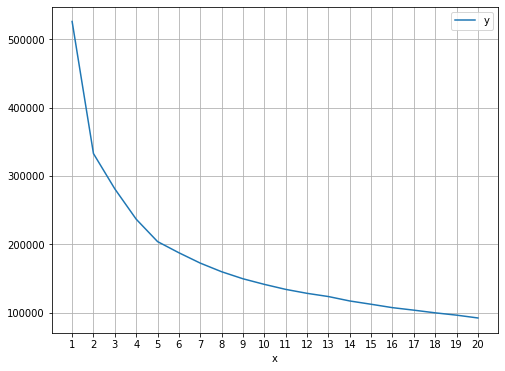

In [20]:
pd.DataFrame(dict(x=range(1,21), y=distortions)).plot(x="x", y="y", xticks=range(1,21), grid=True, figsize=(8,6))

> Using the elbow rule, what is the optimal number of clusters for our dataset?

In [21]:
# set here the optimal number of clusters.
n_clusters = 5

In [ ]:
n_clusters = 5

### Plot the results
Now that we have our optimal settings, we plot our result, including the cluster centers, in an interactive plot so you can change the view and examine the clusters a bit.

In [25]:
est = KMeans(n_clusters=n_clusters, random_state=0).fit(X_transformed)
centers = scaler.inverse_transform(est.cluster_centers_)

plotly.offline.init_notebook_mode(connected=True)

axes = dict(x='Mileage', y='Horsepower', z='Age')
x, y, z = X[:, 1], X[:, 3], X[:, 8]

# taken from https://plot.ly/ipython-notebooks/color-scales/#colorlover
# change plotting code below if you need more than 5 colors
color_scale5  = ['rgb(127,201,127)', 'rgb(190,174,212)', 'rgb(253,192,134)', 'rgb(255,255,153)', 'rgb(56,108,176)']
color_scale10 = ['rgb(141,211,199)', 'rgb(255,255,179)', 'rgb(190,186,218)', 'rgb(251,128,114)', 'rgb(128,177,211)',
                'rgb(253,180,98)', 'rgb(179,222,105)', 'rgb(252,205,229)', 'rgb(217,217,217)', 'rgb(188,128,189)']

points = go.Scatter3d(x=x, y=y ,z=z, mode='markers',
    marker=dict(size=1, opacity=0.8,line=dict(color=[color_scale5[i] for i in est.labels_], width=0.5)))
centers = go.Scatter3d(x=centers[:, 1], y=centers[:, 3] ,z=centers[:, 8], mode='markers',
    marker=dict(size=8, line=dict(color='rgb(255,0,0)', width=1.0)))

layout = go.Layout(
    scene=dict( xaxis=dict(title=axes['x']), yaxis=dict(title=axes['y']), zaxis=dict(title=axes['z'])),
    margin=dict(l=0, r=0, b=0, t=0))

fig = go.Figure(data=[points, centers], layout=layout)
plotly.offline.iplot(fig)

### Only for Information: Overview of clustering algorithms

We have seen the K-Means algorithm in class, which is arguably the most famous clustering algorithms. It works well with a high sample-count and enjoys very diverse applications. But there are many different clustering algorithms, K-Means is just one of them. The following overview, taken straight from [Scikit-Learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py) examples, shows a nice overview over different algorithms.

/Users/jabbathegut/.local/share/virtualenvs/HSLU_ML-myLqnJHJ/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning:

'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.

/Users/jabbathegut/.local/share/virtualenvs/HSLU_ML-myLqnJHJ/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning:

'random_state' has been introduced in 0.23. It will be set to None starting from 0.25 which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.

/Users/jabbathegut/.local/share/virtualenvs/HSLU_ML-myLqnJHJ/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:146: FutureWarning:

'random_state' has been introduced in 0.23. It will

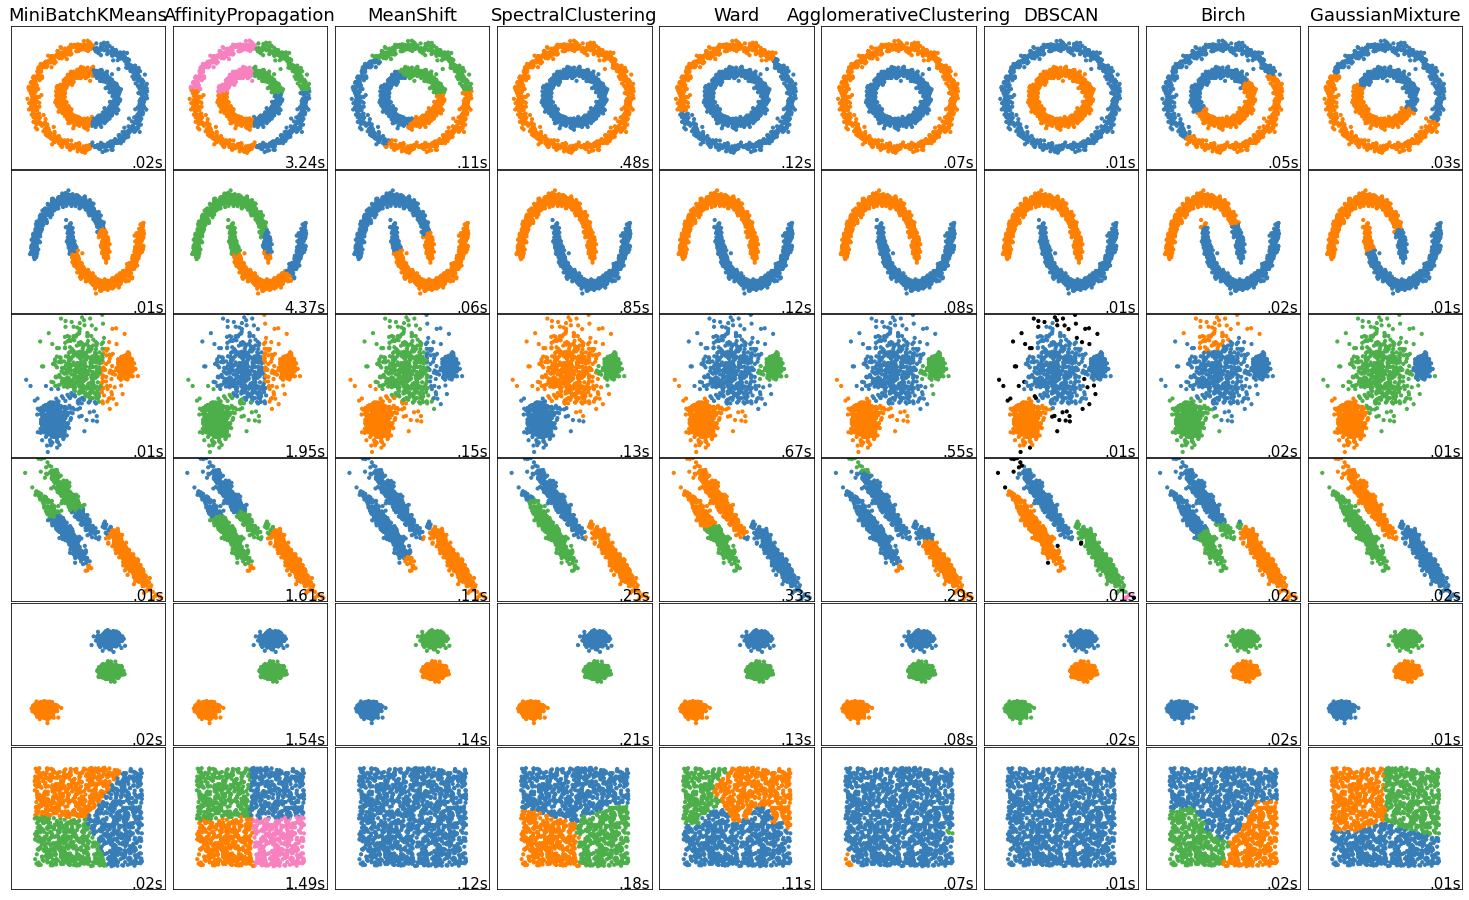

In [26]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240, 'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(tqdm(datasets)):
    
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward',connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack',affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock",n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']), int(max(y_pred) + 1))))
        
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'), transform=plt.gca().transAxes, size=15, horizontalalignment='right')
        plot_num += 1

plt.show()

### Assignment
> Before continuing with the second exercise, answer the question on the ILIAS quiz  **Clustering and Association Rules**.

In [51]:
est = KMeans(n_clusters=5, random_state=0).fit(X_transformed)

> Use our fitted KMeans model with 5 clusters to answer the following question: To which cluster gets a car with the following properties assigned?
* Price = 45000
* Mileage = 20000
* Doors = 5
* Horsepower = 120
* Engine size = 5000
* Seats = 5
* Cylinders = 8
* Gears = 5
* Age = 10

In [55]:
car = [[45000,20000,5,120,5000,5,8,5,10]]
car = scaler.transform(car)
est.predict(car)

array([2], dtype=int32)

## Exercise 2 -  Association Rule Mining
Scikit-Learn does not support association rule learning. Fortunately though, [Sebastian Raschka](https://sebastianraschka.com) (a personal hero of mine) implemented this (and many other cool things) in his library *mlextend*, which aims to be as Scikit-Learn compatible as possible.

You can find examples for generating frequent itemsets with apriori [here](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) and for association rule mining [here](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/).

### Manually
But first, we do a little manual calculation. You are given the following dataset of transactions.

In [25]:
transactions = [['oats', 'lego', 'teddybear', 'rc car'],
                ['oats', 'red coat', 'gloves', 'teddybear', 'doll', 'warm boot'],
                ['lego', 'red jelly bag cap', 'rc car', 'doll'],
                ['lego', 'oats', 'large red bag', 'gift wrap paper', 'warm boot']]

transactions = pd.DataFrame(data={"Items":transactions}, index=range(1,5))
transactions.index.name = 'Id'

with pd.option_context('display.max_colwidth', 80):
    print(transactions)

                                                      Items
Id                                                         
1                           [oats, lego, teddybear, rc car]
2      [oats, red coat, gloves, teddybear, doll, warm boot]
3                   [lego, red jelly bag cap, rc car, doll]
4   [lego, oats, large red bag, gift wrap paper, warm boot]


> Calculate the support for lego, oats and doll (manunally or by code, your choice).

In [26]:
# support_lego = 3/4
# support_oats = 3/4
# support_doll = 2/4

# or with code, for example:
support = {}
for item in ['lego', 'oats', 'doll']:
    support[item] = transactions.Items.map(lambda x: item in x).sum() / transactions.shape[0] # support of 'lego'
support

{'lego': 0.75, 'oats': 0.75, 'doll': 0.5}

In [ ]:
# support_lego = 3/4
# support_oats = 3/4
# support_doll = 2/4

# or with code, for example:
support = {}
for item in ['lego', 'oats', 'doll']:
    support[item] = transactions.Items.map(lambda x: item in x).sum() / transactions.shape[0] # support of 'lego'
support

> Calculate the confidence of `['lego', 'oats'] -> ['teddybear']`

In [27]:
# confidence_lego_oats-teddybear = 0.25 / 0.5
0.25 / ( transactions.Items.map(lambda x: 'lego' in x and 'oats' in x).sum() / transactions.shape[0]  )

0.5

In [ ]:
# confidence_lego_oats-teddybear = 0.25 / 0.5
0.25 / ( transactions.Items.map(lambda x: 'lego' in x and 'oats' in x).sum() / transactions.shape[0]  )

Now apply the Apriori algorithm and find the frequent item sets with a minimum support of 0.5 and minimum confidence of 0.75. Here is the dataset again:

In [28]:
with pd.option_context('display.max_colwidth', 80):
    print(transactions)

                                                      Items
Id                                                         
1                           [oats, lego, teddybear, rc car]
2      [oats, red coat, gloves, teddybear, doll, warm boot]
3                   [lego, red jelly bag cap, rc car, doll]
4   [lego, oats, large red bag, gift wrap paper, warm boot]


> **Step 1**: Generate frequent item sets satisfying the support threshold (hint: there are 6 itemsets of length 1 and 4 itemsets of length 2)

In [30]:
# Execute the following code to show the solution. We will see how to use this library in a minute.
te = TransactionEncoder()
te_ary = te.fit_transform(transactions.Items.values.tolist())
df = pd.DataFrame(te_ary, columns=te.columns_)

freq_itemsets = apriori(df, use_colnames=True, min_support=0.5)
freq_itemsets

support           itemsets
0     0.50             (doll)
1     0.75             (lego)
2     0.75             (oats)
3     0.50           (rc car)
4     0.50        (teddybear)
5     0.50        (warm boot)
6     0.50       (oats, lego)
7     0.50     (rc car, lego)
8     0.50  (teddybear, oats)
9     0.50  (warm boot, oats)

In [29]:
# Execute the following code to show the solution. We will see how to use this library in a minute.
te = TransactionEncoder()
te_ary = te.fit_transform(transactions.Items.values.tolist())
df = pd.DataFrame(te_ary, columns=te.columns_)

freq_itemsets = apriori(df, use_colnames=True, min_support=0.5)
freq_itemsets

support           itemsets
0     0.50             (doll)
1     0.75             (lego)
2     0.75             (oats)
3     0.50           (rc car)
4     0.50        (teddybear)
5     0.50        (warm boot)
6     0.50       (oats, lego)
7     0.50     (rc car, lego)
8     0.50  (teddybear, oats)
9     0.50  (warm boot, oats)

> **Step 2**: Extract rules from frequent item sets satisfying the confidence threshold (hint: there are three itemsets)

In [31]:
# Execute the following code to show the solution
association_rules(freq_itemsets, metric='confidence', min_threshold=0.75)

antecedents consequents  antecedent support  consequent support  support  \
0     (rc car)      (lego)                 0.5                0.75      0.5   
1  (teddybear)      (oats)                 0.5                0.75      0.5   
2  (warm boot)      (oats)                 0.5                0.75      0.5   

   confidence      lift  leverage  conviction  
0         1.0  1.333333     0.125         inf  
1         1.0  1.333333     0.125         inf  
2         1.0  1.333333     0.125         inf

There are 8 candidates: From all 4 itemsets with two items, generate the two possibilities.

From these 8 candidates, 4 have a confidence of 0.5/0.75 which is below the threshold and 4 have a confidence of 0.5/0.5 which is above.

In [ ]:
# Execute the following code to show the solution
association_rules(freq_itemsets, metric='confidence', min_threshold=0.75)

Ok, enough manual calculation with a toy example for today. Let's work with a bigger dataset.

### Automated
You are given some transactional data about purchases in a supermarket.

In [32]:
transactions = pd.read_csv('acostasg.csv')
transactions.columns = ['Date', 'Transaction', 'Item']
transactions.head()

Date  Transaction           Item
0  2000-01-01            1           pork
1  2000-01-01            1  sandwich bags
2  2000-01-01            1     lunch meat
3  2000-01-01            1   all- purpose
4  2000-01-01            1          flour

In [33]:
transactions.shape

(22342, 3)

There is a kind of placeholder item *'all- purpose'* (notice the space after the dash) in the data which appears multiple times in some transactions. 
> Remove rows with this item. 

In [34]:
transactions = transactions[transactions.Item != 'all- purpose']

In [ ]:
transactions = transactions[transactions.Item != 'all- purpose']

In [35]:
transactions.shape

(21791, 3)

#### Group by transaction ID
We group the data by transaction id and aggregate purchases into a list (the Date is constant for s single transaction).

In [36]:
transactions = transactions.groupby('Transaction').agg({'Date':lambda x: x.iloc[0] ,'Item':list})
transactions.head()

Date                                               Item
Transaction                                                               
1            2000-01-01  [pork, sandwich bags, lunch meat, flour, soda,...
2            2000-01-01  [toilet paper, shampoo, hand soap, waffles, ve...
3            2000-01-02  [soda, pork, soap, ice cream, toilet paper, di...
4            2000-01-02   [cereals, juice, lunch meat, soda, toilet paper]
5            2000-01-02  [sandwich loaves, pasta, tortillas, mixes, han...

#### Calculate size for each transaction
We also calculate the size for each transaction.
> `map` the function `len` on each row of the *Item* column.

In [37]:
transactions['Item'].map(len)

Transaction
1       16
2       23
3       31
4        5
5       26
        ..
1135    29
1136    21
1137    26
1138    19
1139     5
Name: Item, Length: 1139, dtype: int64

In [ ]:
transactions['Size'] = transactions['Item'].map(len)
transactions.head()

#### Statistics

In [38]:
transactions.describe()

Date                                               Item
count         1139                                               1139
unique         603                                               1139
top     2001-02-08  [hand soap, bagels, waffles, laundry detergent...
freq             8                                                  1

In [40]:
transactions.hist()

ValueError: hist method requires numerical columns, nothing to plot.

The mlxtend library offers a function to turn a list of transactions into the required binary transaction format: 

In [41]:
te = TransactionEncoder()
te_binary = te.fit_transform(transactions.Item)

df = pd.DataFrame(te_binary, columns=te.columns_)
df.head()

aluminum foil  bagels   beef  butter  cereals  cheeses  coffee/tea  \
0           True   False   True    True    False    False       False   
1           True   False  False   False     True     True       False   
2          False    True  False   False     True     True       False   
3          False   False  False   False     True    False       False   
4          False   False  False   False    False    False       False   

   dinner rolls  dishwashing liquid/detergent   eggs  ...  shampoo   soap  \
0          True                         False  False  ...     True   True   
1         False                          True  False  ...     True  False   
2          True                         False   True  ...     True   True   
3         False                         False  False  ...    False  False   
4          True                         False   True  ...    False  False   

    soda  spaghetti sauce  sugar  toilet paper  tortillas  vegetables  \
0   True            False  False         False      False        True   
1  False            False  False          True       True        True   
2   True             True  False          True      False        True   
3   True            False  False          True      False       False   
4   True             True  False          True       True        True   

   waffles  yogurt  
0    False   False  
1     True    True  
2    False   False  
3    False   False  
4     True    True  

[5 rows x 37 columns]

#### Association Rule Mining
> Generate frequent itemsets with a minimum support of 0.05. Look at the examples linked above or given in the solutions of the toy example for hints.

In [43]:
freq_itemsets = apriori(df, use_colnames=True, min_support=0.05)
freq_itemsets

support                                        itemsets
0      0.384548                                 (aluminum foil)
1      0.385426                                        (bagels)
2      0.374890                                          (beef)
3      0.367867                                        (butter)
4      0.395961                                       (cereals)
...         ...                                             ...
14563  0.058824            (yogurt, vegetables, waffles, sugar)
14564  0.055312  (toilet paper, vegetables, waffles, tortillas)
14565  0.053556   (yogurt, toilet paper, vegetables, tortillas)
14566  0.064969     (yogurt, toilet paper, vegetables, waffles)
14567  0.059701        (yogurt, tortillas, vegetables, waffles)

[14568 rows x 2 columns]

In [ ]:
freq_itemsets = apriori(df, min_support=0.05, use_colnames=True)

> Now extract all association rules with a confidence threshold of 0.5.

In [45]:
rules = association_rules(freq_itemsets, metric='confidence', min_threshold=0.5)
rules.head()

antecedents   consequents  antecedent support  consequent support  \
0  (aluminum foil)  (vegetables)            0.384548            0.739245   
1         (bagels)  (vegetables)            0.385426            0.739245   
2           (beef)  (vegetables)            0.374890            0.739245   
3         (butter)  (vegetables)            0.367867            0.739245   
4        (cereals)  (vegetables)            0.395961            0.739245   

    support  confidence      lift  leverage  conviction  
0  0.310799    0.808219  1.093304  0.026524    1.359651  
1  0.300263    0.779043  1.053836  0.015339    1.180118  
2  0.291484    0.777518  1.051773  0.014348    1.172025  
3  0.283582    0.770883  1.042798  0.011639    1.138087  
4  0.310799    0.784922  1.061789  0.018087    1.212377

In [ ]:
rules = association_rules(freq_itemsets, metric='confidence', min_threshold=0.5)
rules.head()

> Sort this so that the rules with the highest lift are at the top and print the top ten rules.

In [46]:
rules.sort_values('lift', ascending=False).head(n=10)

antecedents      consequents  \
7153                       (pasta, eggs, ice cream)   (paper towels)   
7154                (paper towels, eggs, ice cream)          (pasta)   
2693               (bagels, sandwich bags, cereals)        (cheeses)   
2361          (yogurt, toilet paper, aluminum foil)          (juice)   
2463               (yogurt, aluminum foil, poultry)          (mixes)   
2694                     (bagels, cheeses, cereals)  (sandwich bags)   
6282  (spaghetti sauce, poultry, laundry detergent)   (dinner rolls)   
6169          (spaghetti sauce, poultry, ice cream)   (dinner rolls)   
2338               (yogurt, aluminum foil, poultry)          (juice)   
6168     (spaghetti sauce, dinner rolls, ice cream)        (poultry)   

      antecedent support  consequent support   support  confidence      lift  \
7153            0.085162            0.362599  0.055312    0.649485  1.791193   
7154            0.086040            0.371378  0.055312    0.642857  1.731003   
2693            0.075505            0.390694  0.050922    0.674419  1.726209   
2361            0.078139            0.376646  0.050044    0.640449  1.700401   
2463            0.080773            0.375768  0.050922    0.630435  1.677722   
2694            0.083406            0.367867  0.050922    0.610526  1.659641   
6282            0.083406            0.388938  0.053556    0.642105  1.650921   
6169            0.080773            0.388938  0.051800    0.641304  1.648862   
2338            0.080773            0.376646  0.050044    0.619565  1.644953   
6168            0.075505            0.421422  0.051800    0.686047  1.627931   

      leverage  conviction  
7153  0.024432    1.818468  
7154  0.023358    1.760140  
2693  0.021423    1.871441  
2361  0.020613    1.733703  
2463  0.020570    1.689098  
2694  0.020239    1.623045  
6282  0.021116    1.707380  
6169  0.020384    1.703568  
2338  0.019621    1.638530  
6168  0.019980    1.842877

In [ ]:
rules.sort_values('lift', ascending=False).head(n=10)

You now have a list of rules that are interesting (support >= 0.05), trustworthy (confidence >= 0.5) and are ordered by association strength (lift) between antecedents and consequent.

Finally, let us display our rule set with the three measures support, confidence and lift.

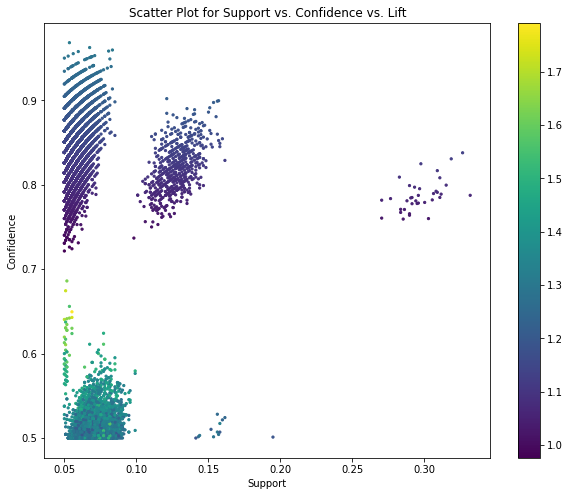

In [47]:
plt.subplots(figsize=(10, 8))
plt.scatter(rules.support, rules.confidence, c=rules.lift, s=5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Scatter Plot for Support vs. Confidence vs. Lift')
plt.colorbar()
plt.show()

We can filter the rules the following way:

In [48]:
rules.query('support > 0.05 and confidence > 0.9 and lift > 1.3')

antecedents   consequents  \
6601  (dishwashing liquid/detergent, sandwich loaves...  (vegetables)   
7433                   (eggs, sandwich loaves, poultry)  (vegetables)   

      antecedent support  consequent support   support  confidence      lift  \
6601            0.055312            0.739245  0.053556    0.968254  1.309788   
7433            0.070237            0.739245  0.067603    0.962500  1.302004   

      leverage  conviction  
6601  0.012667    8.213784  
7433  0.015681    6.953468

> Now filter for the rules in the top right corner (support greater than 0.2 and confidence greater than 0.7). What do these rules have in common? Answer the question on ILIAS

In [49]:
rules.query('support > 0.2 and confidence > 0.7')

antecedents   consequents  antecedent support  \
0                  (aluminum foil)  (vegetables)            0.384548   
1                         (bagels)  (vegetables)            0.385426   
2                           (beef)  (vegetables)            0.374890   
3                         (butter)  (vegetables)            0.367867   
4                        (cereals)  (vegetables)            0.395961   
5                        (cheeses)  (vegetables)            0.390694   
6                     (coffee/tea)  (vegetables)            0.379280   
8                   (dinner rolls)  (vegetables)            0.388938   
9   (dishwashing liquid/detergent)  (vegetables)            0.388060   
10                          (eggs)  (vegetables)            0.389816   
11                         (flour)  (vegetables)            0.352941   
12                        (fruits)  (vegetables)            0.370500   
13                     (hand soap)  (vegetables)            0.345917   
14                     (ice cream)  (vegetables)            0.398595   
15              (individual meals)  (vegetables)            0.375768   
16                         (juice)  (vegetables)            0.376646   
17                       (ketchup)  (vegetables)            0.371378   
18             (laundry detergent)  (vegetables)            0.378402   
19                    (lunch meat)  (vegetables)            0.395083   
20                          (milk)  (vegetables)            0.380158   
21                         (mixes)  (vegetables)            0.375768   
22                  (paper towels)  (vegetables)            0.362599   
23                         (pasta)  (vegetables)            0.371378   
24                          (pork)  (vegetables)            0.355575   
25                       (poultry)  (vegetables)            0.421422   
26                 (sandwich bags)  (vegetables)            0.367867   
27               (sandwich loaves)  (vegetables)            0.349429   
28                       (shampoo)  (vegetables)            0.368745   
29                          (soap)  (vegetables)            0.379280   
30                          (soda)  (vegetables)            0.390694   
31               (spaghetti sauce)  (vegetables)            0.373134   
32                         (sugar)  (vegetables)            0.360843   
33                  (toilet paper)  (vegetables)            0.378402   
34                     (tortillas)  (vegetables)            0.369622   
35                       (waffles)  (vegetables)            0.394205   
36                        (yogurt)  (vegetables)            0.383670   

    consequent support   support  confidence      lift  leverage  conviction  
0             0.739245  0.310799    0.808219  1.093304  0.026524    1.359651  
1             0.739245  0.300263    0.779043  1.053836  0.015339    1.180118  
2             0.739245  0.291484    0.777518  1.051773  0.014348    1.172025  
3             0.739245  0.283582    0.770883  1.042798  0.011639    1.138087  
4             0.739245  0.310799    0.784922  1.061789  0.018087    1.212377  
5             0.739245  0.309043    0.791011  1.070026  0.020225    1.247699  
6             0.739245  0.289728    0.763889  1.033337  0.009347    1.104374  
8             0.739245  0.308165    0.792325  1.071803  0.020645    1.255592  
9             0.739245  0.306409    0.789593  1.068107  0.019538    1.239287  
10            0.739245  0.326602    0.837838  1.133370  0.038433    1.607989  
11            0.739245  0.276558    0.783582  1.059976  0.015648    1.204868  
12            0.739245  0.290606    0.784360  1.061029  0.016715    1.209216  
13            0.739245  0.270413    0.781726  1.057465  0.014695    1.194622  
14            0.739245  0.302897    0.759912  1.027957  0.008238    1.086081  
15            0.739245  0.285338    0.759346  1.027191  0.007553    1.083526  
16            0.739245  0.294118    0.780886  1.056329  0.015684    1.190042  
17            0

> Let's look at the rules which have a lift greater than 1.6. Are these rules interesting?

In [50]:
rules.query('lift > 1.6')

antecedents        consequents  \
2338               (yogurt, aluminum foil, poultry)            (juice)   
2361          (yogurt, toilet paper, aluminum foil)            (juice)   
2463               (yogurt, aluminum foil, poultry)            (mixes)   
2693               (bagels, sandwich bags, cereals)          (cheeses)   
2694                     (bagels, cheeses, cereals)    (sandwich bags)   
4323                     (yogurt, cheeses, cereals)       (coffee/tea)   
4435            (spaghetti sauce, cereals, poultry)     (dinner rolls)   
6013            (pasta, paper towels, dinner rolls)             (eggs)   
6015             (paper towels, eggs, dinner rolls)            (pasta)   
6034                  (soda, dinner rolls, poultry)             (eggs)   
6168     (spaghetti sauce, dinner rolls, ice cream)          (poultry)   
6169          (spaghetti sauce, poultry, ice cream)     (dinner rolls)   
6224              (spaghetti sauce, juice, poultry)     (dinner rolls)   
6282  (spaghetti sauce, poultry, laundry detergent)     (dinner rolls)   
6283     (dinner rolls, poultry, laundry detergent)  (spaghetti sauce)   
7152               (pasta, paper towels, ice cream)             (eggs)   
7153                       (pasta, eggs, ice cream)     (paper towels)   
7154                (paper towels, eggs, ice cream)            (pasta)   

      antecedent support  consequent support   support  confidence      lift  \
2338            0.080773            0.376646  0.050044    0.619565  1.644953   
2361            0.078139            0.376646  0.050044    0.640449  1.700401   
2463            0.080773            0.375768  0.050922    0.630435  1.677722   
2693            0.075505            0.390694  0.050922    0.674419  1.726209   
2694            0.083406            0.367867  0.050922    0.610526  1.659641   
4323            0.081651            0.379280  0.050044    0.612903  1.615965   
4435            0.080773            0.388938  0.050922    0.630435  1.620915   
6013            0.081651            0.389816  0.051800    0.634409  1.627458   
6015            0.086040            0.371378  0.051800    0.602041  1.621098   
6034            0.082529            0.389816  0.051800    0.627660  1.610145   
6168            0.075505            0.421422  0.051800    0.686047  1.627931   
6169            0.080773            0.388938  0.051800    0.641304  1.648862   
6224            0.082529            0.388938  0.051800    0.627660  1.613779   
6282            0.083406            0.388938  0.053556    0.642105  1.650921   
6283            0.089552            0.373134  0.053556    0.598039  1.602745   
7152            0.087796            0.389816  0.055312    0.630000  1.616149   
7153            0.085162            0.362599  0.055312    0.649485  1.791193   
7154            0.086040            0.371378  0.055312    0.642857  1.731003   

      leverage  conviction  
2338  0.019621    1.638530  
2361  0.020613    1.733703  
2463  0.020570    1.689098  
2693  0.021423    1.871441  
2694  0.020239    1.623045  
4323  0.019075    1.603526  
4435  0.019506    1.653463  
6013  0.019971    1.669034  
6015  0.019846    1.579613  
6034  0.019629    1.638781  
6168  0.019980    1.842877  
6169  0.020384    1.703568  
6224  0.019701    1.641139  
6282  0.021116    1.707380  
6283  0.020141    1.559519  
7152  0.021087    1.649147  
7153  0.024432    1.818468  
7154  0.023358    1.760140

That's it for the topic of Association Rules!